In [77]:
import pandas as pd
import numpy as np
import glob, sys, os, time , itertools , warnings , re
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp
# from DataProcessing import 
import uszipcode , pickle 
from TempFolder.TempFolder import Temp
warnings.filterwarnings('ignore')

In [2]:
path_to_csv = '/home/vlad/csv/Cars/'
path_to_output ='/home/vlad/csv/SC-output/'
Temp.set_path('/home/vlad/csv/SC-temp/')
path_to_temp = '/home/vlad/csv/SC-working-folder/'
colummn_names = ['Description'
                 ,'Title State/Type'
                 ,'Location'
                 ,'null'
                 ,'Auction Date'
                 ,'Actual Cash Value'
                 ,'Repair Cost'
                 ,'Odometer'
                 ,'Prim Damage'
                 ,'Sec Damage'
                 ,'Price Sold or Highest Bid']
path_to_makes = glob.glob(path_to_csv+'*')
search = uszipcode.SearchEngine(simple_zipcode=True)
path_to_all_years = list(itertools.chain.from_iterable([glob.glob(path+'/*') for path in path_to_makes]))
search = uszipcode.SearchEngine(simple_zipcode=True)



In [3]:
# #
# #Read and parse scraped .html files 
# def process_files(path_to_years__):
#     res_df = pd.DataFrame()
#     #for each make/year folder get a list of all .html files
#     #for path_to__year in tqdm(path_to_years__):
#     for path_to__year in path_to_years__:
#         try:
#             #list of all html
#             path_to_make_years = glob.glob(path_to__year+'/*')

#             #for each .html in the folder
#             for file_path in path_to_make_years:
#             #file_path = path_to_make_years[0]
            
#                 #read file and load to the BS object
#                 with open(file_path, 'r') as f:
#                     fle = f.read()
#                 soup = BeautifulSoup(fle)

#                 rows = []
#                 line_ind = 0 
                
#                 #filter all div elements (div table)
#                 for div in soup.find_all('div',['row']):
#                     row = div.text.strip()
#                     #print(row)
#                     try:
#                         line_dict = {}
#                         i = 0
                        
#                         #clean each element and map to respected column
#                         for line in row.replace('\t','').replace('\xa0','').split('\n'):
#                             line_dict[colummn_names[i]]= line.replace('Location:','').replace('Title State/Type:','').strip()
#                             i+=1
#                         rows.append(line_dict)
#                     except Exception as e:
#                         #print(line_ind,'-',e)
#                         pass
#                     finally:
#                         line_ind+=1

#                 page_df = pd.DataFrame(rows).iloc[3:,:-1]
#                 page_df_ext = page_df.join(page_df['Description'].str.split(' ',expand=True).rename(columns={0:'Year',1:'Make',2:'Model',3:'Model 2',4:'Model 3'}))
#                 page_df_ext = page_df_ext.join(page_df_ext['Location'].str.split('-',expand=True).rename(columns={0:'State',1:'City'}))
#                 page_df_ext['City'] = page_df_ext['City'].str.strip().str.capitalize()
#                 page_df_ext['State'] = page_df_ext['State'].str.strip()
#                 res_df = res_df.append(page_df_ext,ignore_index=True,sort=False)
#                 del rows , page_df_ext , page_df
#         except:
#             continue
#     return res_df

# %%time

# if __name__ == '__main__':
#     NCPU = mp.cpu_count()
#     print('Creating pool with ', NCPU,' CPUs')
#     pool = mp.Pool(NCPU)
#     if not os.path.exists(path_to_output):
#         print('Creating output folder')
#         os.makedirs(path_to_output)
    
#     by_chunk_path_to_all_years = np.array_split(path_to_all_years,len(path_to_all_years) // 4 )
#     start_ = 0
#     end_ = len(by_chunk_path_to_all_years)
#     for i in range(start_,end_):
#         print('Starting with chunk: ',i,' of ',end_)
#         path_to_all_years_split = np.array_split(by_chunk_path_to_all_years[i],NCPU)
#         ress = pool.map(process_files,path_to_all_years_split)
#         ress_df = pd.concat(ress)
#         print('Chunk ',i,' is done.')
#         ress_df.to_csv(path_to_output+'sc_'+str(i)+'.csv',index=False)
# #         i+=1
# #         if i ==2:
# #             break
#     pool.close()
#     pool.join()
    

In [4]:
#Read parsed files
outputs = glob.glob(path_to_output+'*')
out_l = []
for output in tqdm(outputs):
#     print(output)
    out_l.append(pd.read_csv(output))
out_df = pd.concat(out_l,ignore_index=True,sort=False)

100%|██████████| 321/321 [00:21<00:00, 14.95it/s]


In [5]:


out_df = out_df.join(out_df['Location'].str.split('-',expand=True).rename(columns={0:'State',1:'City'}))

out_df['City'] = out_df['City'].str.strip().str.capitalize()
out_df['State'] = out_df['State'].str.strip().str.upper()

out_df.head(20)

,Actual Cash Value,Auction Date,Description,Location,Odometer,Prim Damage,Repair Cost,Title State/Type,Make,Model,Model 2,Price Sold or Highest Bid,Sec Damage,Year,Model 3,5,State,City,2
0,NaN,11/05/2019,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,Minor dent/scratches,NaN,IL CT,Wabash,DRY,VAN,"$ 3,900 USD",NaN,2005,NaN,NaN,IL,Chicago north,None
1,"$ 8,903 USD",10/23/2019,2005 Wabash DRY VAN,MA - WEST WARREN,0 E,Top/roof,NaN,PA SC,Wabash,DRY,VAN,$ 250 USD,NaN,2005,NaN,NaN,MA,West warren,None
2,NaN,08/27/2019,2005 Wabash DRY VAN,IN - INDIANAPOLIS,0 E,Front end,NaN,IN CT,Wabash,DRY,VAN,"$ 1,400 USD",NaN,2005,NaN,NaN,IN,Indianapolis,None
3,NaN,04/11/2019,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,Side,NaN,IL CT,Wabash,DRY,VAN,"$ 6,500 USD",NaN,2005,NaN,NaN,IL,Chicago north,None
4,NaN,04/11/2019,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,Side,NaN,IL CT,Wabash,DRY,VAN,"$ 7,500 USD",NaN,2005,NaN,NaN,IL,Chicago north,None
5,NaN,03/06/2019,2007 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,Minor dent/scratches,NaN,IL CT,Wabash,DRY,VAN,"$ 7,000 USD",NaN,2007,NaN,NaN,IL,Chicago north,None
6,"$ 14,862 USD",04/29/2019,2010 Wabash DRY VAN,GA - ATLANTA EAST,0 N,Rollover,NaN,GA BP,Wabash,DRY,VAN,"$ 1,600 USD",NaN,2010,NaN,NaN,GA,Atlanta east,None
7,NaN,08/07/2019,2013 Wabash DRY VAN,CA - ANTELOPE,0 N,Minor dent/scratches,NaN,TN SC,Wabash,DRY,VAN,"$ 4,800 USD",NaN,2013,NaN,NaN,CA,Antelope,None
8,"$ 5,725 USD",07/01/2016,2011 Chevrolet HHR LS,MO - ST. LOUIS,146669 A,FRONT END,"$ 5,540.83 USD",MO SC,Chevrolet,HHR,LS,"$ 1,000 USD",MINOR DENT/SCRATCHES,2011,NaN,NaN,MO,St. louis,None
9,"$ 13,125.04 USD",06/30/2016,2011 Chevrolet CAMARO LT,NM - ALBUQUERQUE,95843 A,FRONT END,"$ 12,364.94 USD",UT SC,Chevrolet,CAMARO,LT,"$ 4,500 USD",NaN,2011,NaN,NaN,NM,Albuquerque,None


In [7]:
row_size = out_df.shape[0]

print('Row dataset size: ',row_size)

Row dataset size:  1073859


In [6]:
out_df.groupby('Make')['Year'].count().sort_values(ascending=False)[:60]

Make
Toyota           142641
Honda            110234
Ford             100021
Chevrolet         95540
Nissan            90862
Hyundai           44489
Dodge             41854
BMW               40111
Mercedes-Benz     39617
Jeep              39128
Volkswagen        36164
KIA               29920
Lexus             29696
Chrysler          27465
Subaru            20847
Acura             16863
Audi              15197
Infiniti          15116
Pontiac           14658
Cadillac          13998
GMC               13314
Mitsubishi        12733
Volvo              9654
Lincoln            9611
Saturn             9465
Scion              7642
Land               7369
Mercury            7116
Mini               5623
Jaguar             4818
Porsche            4105
Mazda              2320
Buick              2300
Oldsmobile         2144
Saab               2089
Isuzu              1819
Fiat               1388
Hummer             1231
Maserati            774
Plymouth            676
Tesla               634
Smart      

In [8]:
out_df['Make'] = out_df['Make'].str.strip().str.upper()

out_df.groupby('Make')['Year'].count().sort_values(ascending=False)[:60]

Make
TOYOTA           142682
HONDA            110263
FORD             100053
CHEVROLET         95577
NISSAN            90895
HYUNDAI           44500
DODGE             41869
BMW               40111
MERCEDES-BENZ     39625
JEEP              39140
VOLKSWAGEN        36175
KIA               29920
LEXUS             29700
CHRYSLER          27467
SUBARU            20852
ACURA             16866
AUDI              15199
INFINITI          15120
PONTIAC           14660
CADILLAC          14000
GMC               13314
MITSUBISHI        12738
VOLVO              9658
LINCOLN            9611
SATURN             9467
SCION              7643
LAND               7370
MERCURY            7118
MINI               5626
JAGUAR             4819
PORSCHE            4106
MAZDA              2320
BUICK              2300
OLDSMOBILE         2145
SAAB               2090
ISUZU              1819
FIAT               1388
HUMMER             1231
MASERATI            774
PLYMOUTH            676
TESLA               634
SMART      

In [8]:
#clean up wrong values 
out_df = out_df.loc[~out_df['Actual Cash Value'].str.contains('Odometer').fillna(False)]
out_df = out_df.loc[~out_df['Year'].str.contains('Make').fillna(False)]
out_df = out_df.loc[~out_df['Year'].str.contains('Model:').fillna(False)]
out_df = out_df.loc[~out_df['Auction Date'].str.contains('Repair Cost').fillna(False)]


#filter out canadian cars
out_df = out_df.loc[~out_df['Price Sold or Highest Bid'].str.contains('CA').fillna(False)
                               ]

out_df['Auction Date'] = pd.to_datetime(out_df['Auction Date'])

out_df['Auction_Year'] = out_df['Auction Date'].dt.year

In [14]:
cleaned_size = out_df.shape[0]
print('Cleaned dataset size:',cleaned_size
      ,'\nRows removed: ', row_size - cleaned_size)


Cleaned dataset size: 1071726 
Rows removed:  2133


In [10]:
# # out_df.to_csv(path_to_output+'SC-countymap.csv',index=False)

# # out_df = pd.read_csv(path_to_output+'SC-countymap.csv')

# from DataProcessing.DataStats import get_df_stats

# get_df_stats(out_df)

In [11]:
# Combining Prim Damages 
raw_prim_cat = out_df['Prim Damage'].str.lower().unique()
print('Cat count:',raw_prim_cat.shape[0],'\n',raw_prim_cat)

Cat count: 33 
 ['minor dent/scratches' 'top/roof' 'front end' 'side' 'rollover'
 'rear end' 'vandalism' 'water/flood' 'all over' 'normal wear'
 'undercarriage' 'biohazard/chemical' 'hail' 'mechanical' 'partial repair'
 'rejected repair' 'frame damage' 'stripped' 'damage history' 'burn'
 'burn - engine' 'burn - interior' 'partial/incomplete r'
 'frame damage reporte' 'minor dents/scratche' 'biohazardous/chemica'
 'replaced vin' 'unknown' 'missing/altered vin' 'previous repair' nan
 'cash for clunkers' 'rr']


In [16]:
prim_damage_map = {
 'burn - engine': 'burn'
, 'partial/incomplete r' : 'partial repair'
, 'frame damage reporte' : 'frame damage'

,'unknown' : 'no data'


, np.nan : 'no data'
,'price sold or highest bid' :'no data'
,'rr' : 'no data'

}
out_df['Prim Damage'] = out_df['Prim Damage'].str.lower().replace(prim_damage_map)

In [13]:
new_prim_cat = out_df['Prim Damage'].str.lower().unique()
print('Cat count:',new_prim_cat.shape[0],'\n',new_prim_cat)

Cat count: 28 
 ['minor dent/scratches' 'top/roof' 'front end' 'side' 'rollover'
 'rear end' 'vandalism' 'water/flood' 'all over' 'normal wear'
 'undercarriage' 'biohazard/chemical' 'hail' 'mechanical' 'partial repair'
 'rejected repair' 'frame damage' 'stripped' 'damage history' 'burn'
 'burn - interior' 'minor dents/scratche' 'biohazardous/chemica'
 'replaced vin' 'no data' 'missing/altered vin' 'previous repair'
 'cash for clunkers']


In [14]:
# Temp.save_obj(out_df)#140520646600464

Object <140520646600464> saved to: /home/vlad/csv/SC-temp/


In [8]:
out_df = Temp.load_obj('140520646600464')

Object <140520646600464> loaded from: /home/vlad/csv/SC-temp/


In [9]:
#fix numerical values
def alter_sting(x):    
    try:
        return float(re.sub('[\$,USD,\, ,E,A,N]','',x))
    except:
#         print(x)
        return np.nan


out_df['Actual Cash Value'] = (out_df['Actual Cash Value']
                               #.fillna(-1)
                               .map(alter_sting))
out_df['Repair Cost'] = (out_df['Repair Cost']
#                          .fillna(-1)
                         .map(alter_sting))

out_df['Price Sold or Highest Bid'] = (out_df['Price Sold or Highest Bid']
                                       #.fillna(-1)
                                       .map(alter_sting))
out_df['Year'] = (out_df['Year']
#                   .fillna(-1)
                  .map(float))

out_df = out_df.rename(columns={'Year':'Model_Year'
                               }
                      ).assign(Model_Year = lambda x: pd.to_datetime(x['Model_Year'].astype(int).astype(str)))





In [10]:
#format odometer data

#for null model - replace all E  & N values into "No Data" (np.nan)

def odometer_null(x):
    if 'E' in x or 'N' in x:
        return np.nan
    else:
        return alter_sting(x)


    
#create a dictionary for max E value for each model 

odometr_dict = (out_df.loc[out_df['Odometer'].str.contains('A')]
                 .assign(odometer_num = lambda x: x['Odometer'].map(alter_sting)
                        )
                 .groupby('Description')['odometer_num']
                 .max()
                #  [['Odometer','odometer_num']]
                )

#replace E and N values into max of A category
def odometer_replace(x):
    if 'E' in x['Odometer'] or 'N' in x['Odometer']:
        try:
            return odometr_dict[x['Description']]
        except:
            return np.nan
    else:
        return alter_sting(x['Odometer'])


#create null model
out_df = out_df.assign(odometer_null = lambda x: x['Odometer'].map(odometer_null))

#create replace model:

out_df = out_df.assign(odometer_replace = lambda x: x.apply(odometer_replace,axis=1))


# create Model_Age
# current_year = 2019
out_df['Model_Age'] = (out_df['Auction Date'] - out_df['Model_Year'] ).dt.days

In [38]:
numerical_fields_odom_null = ['Actual Cash Value','Repair Cost'
                              ,'Price Sold or Highest Bid','Model_Age','odometer_null','Auction_Year']
numerical_fields_odom_replace = ['Actual Cash Value','Repair Cost','Price Sold or Highest Bid','Model_Age','odometer_replace']
categorical_variables = ['Description','Prim Damage','Make','Model_Year']


In [90]:
Temp.save_obj(out_df)

File <140505604672312> saved to: /home/vlad/csv/SC-temp/


In [34]:
out_df[numerical_fields_odom_replace].describe()

,Actual Cash Value,Repair Cost,Price Sold or Highest Bid,Model_Age,odometer_replace
count,839697.000000,3.893880e+05,1.071726e+06,1.071726e+06,1.061972e+06
mean,11425.732472,1.053476e+04,3.350339e+03,3.627110e+03,1.821274e+05
std,11606.300017,1.923140e+04,6.050592e+03,2.246908e+03,1.921757e+05
min,100.000000,1.000000e-02,0.000000e+00,-2.100000e+02,0.000000e+00
25%,4821.000000,6.005000e+03,8.500000e+02,1.994000e+03,8.151200e+04
50%,8400.000000,9.129000e+03,1.800000e+03,3.594000e+03,1.515625e+05
75%,14292.000000,1.305436e+04,3.800000e+03,4.871000e+03,2.520300e+05
max,1000000.000000,9.999999e+06,2.000000e+06,3.454600e+04,9.600091e+06


In [35]:
out_df[numerical_fields_odom_null].describe()

,Actual Cash Value,Repair Cost,Price Sold or Highest Bid,Model_Age,odometer_null,Auction_Year
count,839697.000000,3.893880e+05,1.071726e+06,1.071726e+06,6.705450e+05,1.071726e+06
mean,11425.732472,1.053476e+04,3.350339e+03,3.627110e+03,1.101246e+05,2.016557e+03
std,11606.300017,1.923140e+04,6.050592e+03,2.246908e+03,7.141853e+04,2.050519e+00
min,100.000000,1.000000e-02,0.000000e+00,-2.100000e+02,0.000000e+00,2.010000e+03
25%,4821.000000,6.005000e+03,8.500000e+02,1.994000e+03,5.470300e+04,2.015000e+03
50%,8400.000000,9.129000e+03,1.800000e+03,3.594000e+03,1.066030e+05,2.017000e+03
75%,14292.000000,1.305436e+04,3.800000e+03,4.871000e+03,1.558450e+05,2.018000e+03
max,1000000.000000,9.999999e+06,2.000000e+06,3.454600e+04,9.600091e+06,2.019000e+03


In [36]:
out_df.columns

Index([        'Actual Cash Value',              'Auction Date',
                     'Description',                  'Location',
                        'Odometer',               'Prim Damage',
                     'Repair Cost',          'Title State/Type',
                            'Make',                     'Model',
                         'Model 2', 'Price Sold or Highest Bid',
                      'Sec Damage',                'Model_Year',
                         'Model 3',                         '5',
                           'State',                      'City',
                                 2,              'Auction_Year',
                   'odometer_null',          'odometer_replace',
                       'Model_Age'],
      dtype='object')

In [39]:
out_df[categorical_variables]

from DataProcessing.DataStats import get_df_stats

get_df_stats(out_df[categorical_variables])

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,dtype
0,Description,26399,0.0,0.206769,object
1,Prim Damage,28,0.0,41.468248,object
2,Make,61,0.0,13.295189,object
3,Model_Year,94,0.0,7.254746,datetime64[ns]


In [40]:
#value distribution for Description 

desc_val_dist = out_df['Description'].value_counts()

desc_val_dist[:30]

2015 Nissan ALTIMA 2.5     2216
2008 Nissan ALTIMA 2.5     2062
2013 Nissan ALTIMA 2.5     1880
2003 Honda ACCORD EX       1801
2003 Toyota COROLLA CE     1777
2009 Nissan ALTIMA 2.5     1763
2007 Toyota CAMRY NEW      1722
2002 Toyota CAMRY LE/X     1706
2005 Toyota COROLLA CE     1686
2014 Ford FOCUS SE         1623
2006 Toyota COROLLA CE     1620
2004 Honda ACCORD EX       1585
2012 Honda CIVIC LX        1580
2013 Hyundai ELANTRA GL    1558
2014 Nissan ALTIMA 2.5     1474
2002 Toyota CAMRY LE       1434
2002 Ford EXPLORER X       1427
2003 Toyota CAMRY LE/X     1425
2005 Nissan ALTIMA S/S     1389
2012 Nissan ALTIMA 2.5     1388
2004 Toyota COROLLA CE     1381
2007 Toyota PRIUS          1376
2007 Nissan ALTIMA 2.5     1374
2007 Toyota COROLLA CE     1359
2007 Toyota CAMRY CE/L     1358
2008 Toyota PRIUS          1286
2005 Toyota PRIUS          1286
2008 Honda CIVIC LX        1254
2004 Ford EXPLORER X       1222
2003 Toyota CAMRY LE       1221
Name: Description, dtype: int64

In [41]:
#value distribution for Prim Damage 

prim_val_dist = out_df['Prim Damage'].value_counts()

prim_val_dist[:30]

front end               444426
rear end                106475
mechanical              106405
minor dent/scratches     96005
side                     93991
normal wear              53114
water/flood              33331
all over                 33250
minor dents/scratche     25236
hail                     12474
rollover                 12206
damage history           11908
undercarriage             8856
partial repair            8332
vandalism                 6340
frame damage              5099
burn                      3998
top/roof                  3633
stripped                  3099
biohazard/chemical        1426
burn - interior            924
previous repair            390
rejected repair            350
biohazardous/chemica       152
missing/altered vin        115
replaced vin                96
no data                     94
cash for clunkers            1
Name: Prim Damage, dtype: int64

In [43]:
%%time
# i = 6
# city = out_df.loc[i,'City']
# state =out_df.loc[i,'State']
# city, state

# geo_found = search.by_city_and_state(city,state)[0]

# geo_found.county , geo_found.state


def find_county(x):
    try:
        return search.by_city_and_state(x[1] , x[0])[0].county
    except:
        return 'None'


locs = out_df['Location'].unique()
locs = locs[~pd.isnull(locs)]

state_city = [l[:2] for l in  list(map(lambda x: x.split(' - '),   locs ) ) #if len(l)>1
             ]





county = list(map(find_county,   state_city ) )

county = [', '.join([l.strip() for l in (county[i].replace('County','')+', '+state_city[i][0]).split(',') ])
 for i in range(len(county))]

loc_lookup = pd.DataFrame({'Location':locs,'County':county}).set_index('Location')['County']

loc_lookup


def map_countries(x):
    try:
        return loc_lookup.loc[x]
    except:
        return 'None'
        
out_df['County'] = out_df['Location'].map(map_countries)

CPU times: user 2min 23s, sys: 444 ms, total: 2min 23s
Wall time: 2min 24s


In [44]:
out_df.head(10)

,Actual Cash Value,Auction Date,Description,Location,Odometer,Prim Damage,Repair Cost,Title State/Type,Make,Model,...,Model 3,5,State,City,2,Auction_Year,odometer_null,odometer_replace,Model_Age,County
0,NaN,2019-11-05,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,minor dent/scratches,NaN,IL CT,WABASH,DRY,...,NaN,NaN,IL,Chicago north,None,2019,NaN,NaN,5421,"Lake, IL"
1,8903.00,2019-10-23,2005 Wabash DRY VAN,MA - WEST WARREN,0 E,top/roof,NaN,PA SC,WABASH,DRY,...,NaN,NaN,MA,West warren,None,2019,NaN,NaN,5408,"None, MA"
2,NaN,2019-08-27,2005 Wabash DRY VAN,IN - INDIANAPOLIS,0 E,front end,NaN,IN CT,WABASH,DRY,...,NaN,NaN,IN,Indianapolis,None,2019,NaN,NaN,5351,"Marion, IN"
3,NaN,2019-04-11,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,side,NaN,IL CT,WABASH,DRY,...,NaN,NaN,IL,Chicago north,None,2019,NaN,NaN,5213,"Lake, IL"
4,NaN,2019-04-11,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,side,NaN,IL CT,WABASH,DRY,...,NaN,NaN,IL,Chicago north,None,2019,NaN,NaN,5213,"Lake, IL"
5,NaN,2019-03-06,2007 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,minor dent/scratches,NaN,IL CT,WABASH,DRY,...,NaN,NaN,IL,Chicago north,None,2019,NaN,NaN,4447,"Lake, IL"
6,14862.00,2019-04-29,2010 Wabash DRY VAN,GA - ATLANTA EAST,0 N,rollover,NaN,GA BP,WABASH,DRY,...,NaN,NaN,GA,Atlanta east,None,2019,NaN,NaN,3405,"Fulton, GA"
7,NaN,2019-08-07,2013 Wabash DRY VAN,CA - ANTELOPE,0 N,minor dent/scratches,NaN,TN SC,WABASH,DRY,...,NaN,NaN,CA,Antelope,None,2019,NaN,NaN,2409,"Sacramento, CA"
8,5725.00,2016-07-01,2011 Chevrolet HHR LS,MO - ST. LOUIS,146669 A,front end,5540.83,MO SC,CHEVROLET,HHR,...,NaN,NaN,MO,St. louis,None,2016,146669.0,146669.0,2008,"St. Charles, MO"
9,13125.04,2016-06-30,2011 Chevrolet CAMARO LT,NM - ALBUQUERQUE,95843 A,front end,12364.94,UT SC,CHEVROLET,CAMARO,...,NaN,NaN,NM,Albuquerque,None,2016,95843.0,95843.0,2007,"Bernalillo, NM"


In [60]:
#read the demography data 

path_to_demograpyh ='/home/vlad/csv/SC-output/demography.csv'

demog = pd.read_csv(path_to_demograpyh)

In [61]:
out_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1071726 entries, 0 to 1073858
Data columns (total 24 columns):
Actual Cash Value            839697 non-null float64
Auction Date                 1071726 non-null datetime64[ns]
Description                  1071726 non-null object
Location                     1071689 non-null object
Odometer                     1071726 non-null object
Prim Damage                  1071726 non-null object
Repair Cost                  389388 non-null float64
Title State/Type             1071725 non-null object
Make                         1071726 non-null object
Model                        1071677 non-null object
Model 2                      815589 non-null object
Price Sold or Highest Bid    1071726 non-null float64
Sec Damage                   467809 non-null object
Model_Year                   1071726 non-null datetime64[ns]
Model 3                      47641 non-null object
5                            265 non-null object
State                        1

In [62]:
car_demo_joined = pd.merge(out_df, demog,left_on='County',right_on='index',how='left').drop(columns=['index',2,'5'])

In [63]:
car_demo_joined.head()

,Actual Cash Value,Auction Date,Description,Location,Odometer,Prim Damage,Repair Cost,Title State/Type,Make,Model,...,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018
0,NaN,2019-11-05,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,minor dent/scratches,NaN,IL CT,WABASH,DRY,...,703396.0,704192.0,701647.0,702213.0,704462.0,704618.0,704995.0,704644.0,703006.0,700832.0
1,8903.0,2019-10-23,2005 Wabash DRY VAN,MA - WEST WARREN,0 E,top/roof,NaN,PA SC,WABASH,DRY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2019-08-27,2005 Wabash DRY VAN,IN - INDIANAPOLIS,0 E,front end,NaN,IN CT,WABASH,DRY,...,903389.0,904602.0,911188.0,919700.0,929345.0,935449.0,939406.0,944139.0,948952.0,954670.0
3,NaN,2019-08-27,2005 Wabash DRY VAN,IN - INDIANAPOLIS,0 E,front end,NaN,IN CT,WABASH,DRY,...,70063.0,69906.0,69614.0,69083.0,68850.0,68336.0,67486.0,66680.0,66282.0,65936.0
4,NaN,2019-04-11,2005 Wabash DRY VAN,IL - CHICAGO NORTH,0 E,side,NaN,IL CT,WABASH,DRY,...,703396.0,704192.0,701647.0,702213.0,704462.0,704618.0,704995.0,704644.0,703006.0,700832.0


In [64]:
car_demo_joined.columns

Index(['Actual Cash Value', 'Auction Date', 'Description', 'Location',
       'Odometer', 'Prim Damage', 'Repair Cost', 'Title State/Type', 'Make',
       'Model', 'Model 2', 'Price Sold or Highest Bid', 'Sec Damage',
       'Model_Year', 'Model 3', 'State', 'City', 'Auction_Year',
       'odometer_null', 'odometer_replace', 'Model_Age', 'County',
       'Unemp-Pct-2014', 'Unemp-Pct-2015', 'Unemp-Pct-2016', 'Unemp-Pct-2017',
       'Unemp-Pct-2018', 'Unemp-Pct-2013', 'Unemp-Pct-2012', 'Unemp-Pct-2011',
       'Unemp-Pct-2010', 'Income_adj-1990', 'Income_adj-1991',
       'Income_adj-1992', 'Income_adj-1993', 'Income_adj-1994',
       'Income_adj-1995', 'Income_adj-1996', 'Income_adj-1997',
       'Income_adj-1998', 'Income_adj-1999', 'Income_adj-2000',
       'Income_adj-2001', 'Income_adj-2002', 'Income_adj-2003',
       'Income_adj-2004', 'Income_adj-2005', 'Income_adj-2006',
       'Income_adj-2007', 'Income_adj-2008', 'Income_adj-2009',
       'Income_adj-2010', 'Income_adj-2011', 

In [66]:
car_demo_joined.to_csv(path_to_temp+'joint_working_df.csv')

In [65]:
path_to_temp

'/home/vlad/csv/SC-working-folder/'

In [74]:
by_couny = (car_demo_joined.reset_index()
             .groupby('County')['index']
             .count().sort_values(ascending=False)
           )

print(by_couny.to_string())

County
Los Angeles, CA                68045
Harris, TX                     45330
Dallas, TX                     37503
Fulton, GA                     36862
Miami-Dade, FL                 34789
Sacramento, CA                 27177
San Bernardino, CA             26214
Suffolk, MA                    23868
Hartford, CT                   23349
Orange, NY                     23080
Contra Costa, CA               22409
Philadelphia, PA               19777
Hennepin, MN                   19593
Denver, CO                     19504
San Diego, CA                  17881
Lake, IL                       17156
Queens, NY                     16627
Fresno, CA                     15452
Allegheny, PA                  15360
Cook, IL                       15085
Somerset, NJ                   14846
Maricopa, AZ                   13499
Peoria, IL                     13370
Marion, IN                     13134
Monroe, NY                     11662
Orange, FL                     11650
Hillsborough, FL               

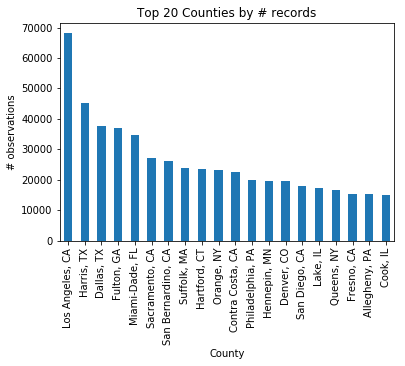

In [81]:
plt.figure()
ax = by_couny[:20].plot.bar()
ax.set(title='Top 20 Counties by # records',ylabel='# observations');